In [28]:
import sys
import warnings
warnings.filterwarnings('ignore')
import os
import copy
import numpy as np
import pandas as pd
from numpy import percentile
from itertools import product
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    f1_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import scipy
from scipy import stats
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import arma_generate_sample
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.express as px
import chart_studio.plotly as py
import seaborn as sns
init_notebook_mode(connected=True)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv(r'C:\Users\aya_h\OneDrive\Desktop\Амира\data.csv')
df.head()

,DATE_USD,USD,LN_USD,DATE_RES,RES,LN_RES,DATE_GDP,GDP,LN_GDP,DATE_GZP,GZP,LN_GZP
0,2007-08-20,25.78,NaN,2007-08-03,416.8,NaN,2002.0,369.90,NaN,2007-08-20,261.49,NaN
1,2007-08-21,25.87,34.84,2007-08-10,420.2,81.24,2003.0,460.74,21.96,2007-08-21,258.89,-9.99
2,2007-08-22,25.77,-40.66,2007-08-17,414.7,-131.75,2004.0,632.76,31.73,2007-08-22,263.56,17.88
3,2007-08-23,25.75,-8.93,2007-08-24,413.8,-21.73,2005.0,817.75,25.65,2007-08-23,264.19,2.39
4,2007-08-24,25.68,-25.67,2007-08-31,416.0,53.02,2006.0,1059.99,25.95,2007-08-24,262.19,-7.60


In [3]:
usd=pd.read_csv(r'C:\Users\aya_h\OneDrive\Desktop\Амира\data.csv',parse_dates=['DATE_USD'],index_col=['DATE_USD'])
usd.LN_USD =usd.LN_USD/100
usd=usd.iloc[:,0:2]
usd.head()

,USD,LN_USD
DATE_USD,,
2007-08-20,25.78,NaN
2007-08-21,25.87,0.3484
2007-08-22,25.77,-0.4066
2007-08-23,25.75,-0.0893
2007-08-24,25.68,-0.2567


In [4]:
test = sm.tsa.stattools.adfuller(usd.LN_USD['2007-08-21':'2023-03-13'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -11.514402620531095
p-value:  4.184065687012316e-21
Critical values:  {'1%': -3.431597617063335, '5%': -2.862091317478062, '10%': -2.5670634659915716}
единичных корней нет, ряд стационарен


In [5]:
train = usd.LN_USD['2013-08-22':'2014-08-22']
test = usd.LN_USD['2014-08-22':'2015-05-02']
print(len(train))
print(len(test))

ps = range(0, 6)
d= range (0,2)
qs = range(0, 6)
parameters = product(ps,d,qs)
parameters_list = list(parameters)
len(parameters_list)


results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
 #try except необходим, так как на некоторых наборах параметров модель не обучается
    try:
        model=sma.tsa.statespace.SARIMAX(train, order=(param[0], param[1], 
param[2])).fit(disp=-1)
 #вывод параметров, на которых модель не обучается и переход к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
 #сохранить лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(5))

342
244
   parameters         aic
26  (2, 0, 2)  497.079398
27  (2, 0, 3)  498.099600
0   (0, 0, 0)  499.233111
38  (3, 0, 2)  499.502343
24  (2, 0, 0)  499.598142


In [6]:
arima1 = ARIMA(train, order=(2, 0, 2)).fit()
print(arima1.summary())

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                 LN_USD   No. Observations:                  342
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -243.089
Date:                Wed, 24 May 2023   AIC                            498.179
Time:                        12:40:59   BIC                            521.187
Sample:                             0   HQIC                           507.345
                                - 342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0245      0.026      0.928      0.354      -0.027       0.076
ar.L1          0.8978      0.034     26.149      0.000       0.830       0.965
ar.L2         -0.9703      0.029    -33.166      0.0

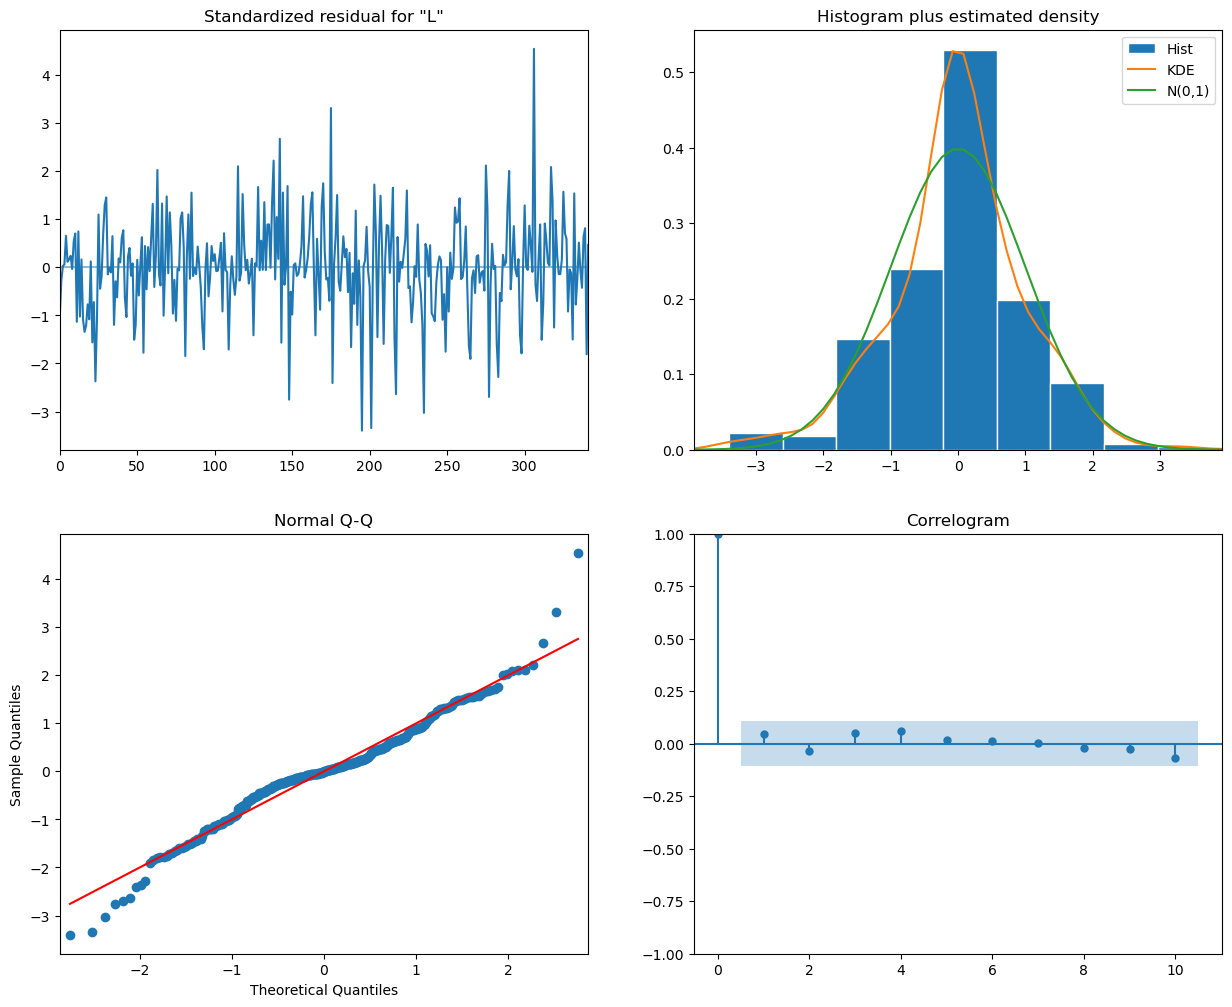

In [80]:
sm.stats.stattools.durbin_watson(arima1.resid.values)
arima1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [9]:
pr1 = arima1.predict( start=len(train),end=len(train)+len(test)-1,dynamic=False).to_numpy()
df_res = usd['2014-08-22':'2015-05-02'].copy()
df_res['fact'] = test
df_res['forecast'] = pr1
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast) 

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold

a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="Логарифм отношения котитровок USD/RUB")

In [10]:
a = df_res.loc[df_res.anomaly, ['USD']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.USD, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.USD, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="USD/RUB")

In [11]:
GZP=pd.read_csv(r'C:\Users\aya_h\OneDrive\Desktop\Амира\data.csv',parse_dates=['DATE_GZP'],index_col=['DATE_GZP'])
GZP.LN_GZP =GZP.LN_GZP/100
GZP=GZP.iloc[:3896,9:11]
GZP.head()

,GZP,LN_GZP
DATE_GZP,,
2007-08-20,261.49,NaN
2007-08-21,258.89,-0.0999
2007-08-22,263.56,0.1788
2007-08-23,264.19,0.0239
2007-08-24,262.19,-0.0760


In [12]:
test = sm.tsa.stattools.adfuller(GZP.LN_GZP['2007-08-21':'2023-03-17'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -10.960245022978023
p-value:  8.361664044808257e-20
Critical values:  {'1%': -3.4320456867492983, '5%': -2.8622892614314974, '10%': -2.5671688411269202}
единичных корней нет, ряд стационарен


In [13]:
train2 = GZP.LN_GZP['2011-05-24':'2014-06-24']
test2 = GZP.LN_GZP['2014-06-24':'2015-01-05']
print(len(train2))
print(len(test2))

ps = range(0, 6)
d= range (0,2)
qs = range(0, 6)
from itertools import product
parameters = product(ps,d,qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
 #try except необходим, так как на некоторых наборах параметров модель не обучается
    try:
        model=sma.tsa.statespace.SARIMAX(train2, order=(param[0], param[1], 
param[2])).fit(disp=-1)
 #вывод параметров, на которых модель не обучается и переход к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
 #сохранить лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(5))

778
136
   parameters         aic
26  (2, 0, 2) -462.305546
39  (3, 0, 3) -461.919377
0   (0, 0, 0) -460.622552
65  (5, 0, 5) -459.174536
12  (1, 0, 0) -459.098953


In [14]:
arima2 = ARIMA(train2, order=(2, 0, 2)).fit()
print(arima2.summary())

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                 LN_GZP   No. Observations:                  778
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 236.057
Date:                Wed, 24 May 2023   AIC                           -460.114
Time:                        12:49:38   BIC                           -432.174
Sample:                             0   HQIC                          -449.367
                                - 778                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.007     -0.428      0.669      -0.016       0.011
ar.L1          0.9289      0.013     69.774      0.000       0.903       0.955
ar.L2         -0.9881      0.012    -80.666      0.0

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



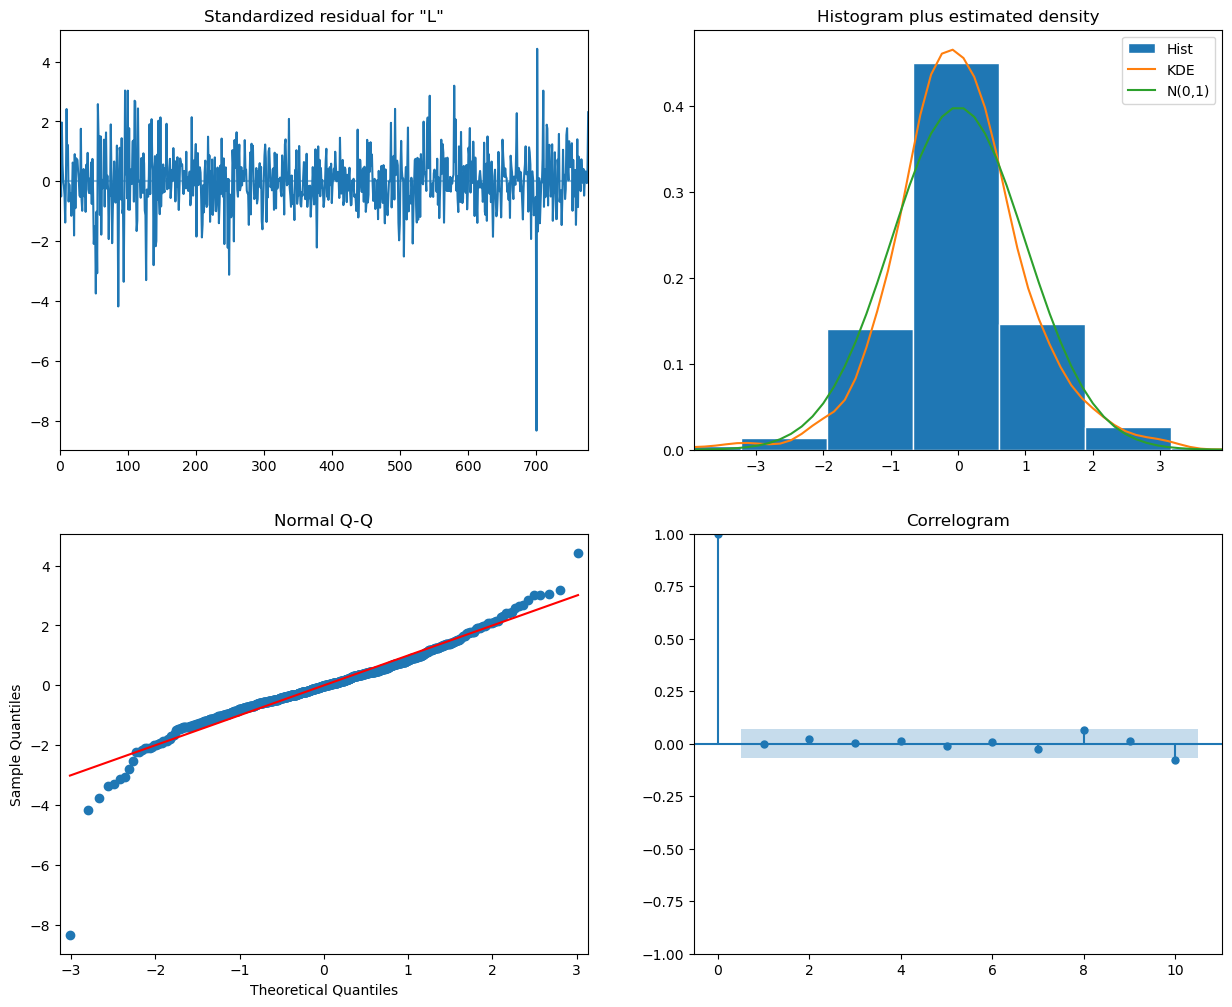

In [15]:
sm.stats.stattools.durbin_watson(arima2.resid.values)
arima2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [16]:
pr2 = arima2.predict(start=len(train2),end=len(train2)+len(test2)-1,dynamic=False).to_numpy()
df_res = GZP['2014-06-24':'2015-01-05'].copy()
df_res['fact'] = test2
df_res['forecast'] = pr2
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast) 
threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold
a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: DeprecationWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [17]:
a = df_res.loc[df_res.anomaly, ['GZP']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.GZP, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.GZP, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title=' Акции "Газпром"')

In [18]:
n_samples = 10000
arparams = np.array([1.5, -0.75])
sigma2 = 1.
gen = np.random.RandomState(1234345)
n_outliers=0

x_values = np.arange(n_samples)
y_values = arma_generate_sample(
    ar=np.r_[1, -arparams],
    ma=np.array([1.]),
    burnin=50,
    scale=np.sqrt(sigma2),
    nsample=n_samples,
    distrvs=gen.standard_normal,
)
outliers_mask = np.zeros(n_samples, dtype=bool)
d1=pd.DataFrame(x_values, columns=['x_values'])
d1['y_values']=y_values
d1['outliers_mask']=outliers_mask

print(f'dataset.n_samples = {n_samples}')
print(f'dataset.n_outliers = {n_outliers}')
d1.head()

dataset.n_samples = 10000
dataset.n_outliers = 0


,x_values,y_values,outliers_mask
0,0,1.037367,False
1,1,1.664399,False
2,2,2.700016,False
3,3,2.943488,False
4,4,2.311552,False


In [19]:
train = d1.y_values[400:500]
test =d1.y_values[500:700]
print(len(train))
print(len(test))

ps = range(0, 5)
d= range (0,1)
qs = range(0, 5)
from itertools import product
parameters = product(ps,d,qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
 #try except необходим, так как на некоторых наборах параметров модель не обучается
    try:
        model=sma.tsa.statespace.SARIMAX(train, order=(param[0], param[1], 
param[2])).fit(disp=-1)
 #вывод параметров, на которых модель не обучается и переход к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
 #сохранить лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(5))

100
200
   parameters         aic
10  (2, 0, 0)  269.309452
16  (3, 0, 1)  270.892074
15  (3, 0, 0)  271.302914
11  (2, 0, 1)  271.304280
20  (4, 0, 0)  272.305963


In [20]:
arima1 = ARIMA(train, order=(2, 0, 0)).fit()
print(arima1.summary())

                               SARIMAX Results                                
Dep. Variable:               y_values   No. Observations:                  100
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -131.606
Date:                Wed, 24 May 2023   AIC                            271.212
Time:                        12:49:59   BIC                            281.633
Sample:                             0   HQIC                           275.429
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1133      0.367      0.308      0.758      -0.607       0.833
ar.L1          1.4998      0.063     23.777      0.000       1.376       1.623
ar.L2         -0.7453      0.070    -10.723      0.0

In [21]:
pr1 = arima1.predict( start=len(train),end=len(train)+len(test)-1,dynamic=False).to_numpy()

df_res = d1[500:700].copy()
df_res['fact'] = test
df_res['forecast'] = pr1
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast)

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold
a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
fig.update_layout(title=f"T = {len(train)}")

fig.show()
f,t=df_res.anomaly.value_counts()
print(f'n_outliers = {t}')
f=t/len(test)
print(f'FPR = {f}')

n_outliers = 10
FPR = 0.05


In [76]:
P_OUTLIER = 0.01
N = 500
n_samples = 10000

x_values = x_values
y_values = y_values

gen = np.random.RandomState(12345)
outliers_mask = np.concatenate([
    np.zeros(N, dtype=bool), 
    gen.choice(2, p=[1 - P_OUTLIER, P_OUTLIER], size=n_samples - N).astype(bool)
])

outliers_magnitudes = gen.standard_t(3, size=n_samples)
outliers_magnitudes = 3 * np.sign(outliers_magnitudes) + 3 * outliers_magnitudes
y_values += outliers_mask * outliers_magnitudes

d2=pd.DataFrame(x_values, columns=['x_values'])
d2['y_values']=y_values
d2['outliers_mask']=outliers_mask

print(f'dataset.n_samples = {n_samples}')
print(f'dataset.n_outliers = {n_outliers}')
d2.head()

dataset.n_samples = 10000
dataset.n_outliers = 0


,x_values,y_values,outliers_mask
0,0,1.037367,False
1,1,1.664399,False
2,2,2.700016,False
3,3,2.943488,False
4,4,2.311552,False


In [77]:
train2 = d2.y_values[0:500]
test2 =d2.y_values[500:700]
print(len(train))
print(len(test))

ps = range(0, 5)
d= range (0,1)
qs = range(0, 5)
from itertools import product
parameters = product(ps,d,qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
 #try except необходим, так как на некоторых наборах параметров модель не обучается
    try:
        model=sma.tsa.statespace.SARIMAX(train2, order=(param[0], param[1], 
param[2])).fit(disp=-1)
 #вывод параметров, на которых модель не обучается и переход к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
 #сохранить лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(5))

100
200
   parameters          aic
16  (3, 0, 1)  1401.074800
18  (3, 0, 3)  1404.172261
14  (2, 0, 4)  1404.731905
19  (3, 0, 4)  1405.057409
10  (2, 0, 0)  1405.387973


In [78]:
arima2 = ARIMA(train2, order=(3, 0, 1)).fit()
print(arima2.summary())

                               SARIMAX Results                                
Dep. Variable:               y_values   No. Observations:                  500
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -695.110
Date:                Wed, 24 May 2023   AIC                           1402.220
Time:                        13:01:12   BIC                           1427.508
Sample:                             0   HQIC                          1412.143
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0656      0.055      1.194      0.233      -0.042       0.173
ar.L1          2.4036      0.043     55.556      0.000       2.319       2.488
ar.L2         -2.0972      0.078    -26.946      0.0

C:\Users\aya_h\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [152]:
pr2 = arima2.predict( start=len(train2),end=len(train2)+len(test2)-1,dynamic=False).to_numpy()
df_res= d2[500:700].copy()
df_res['fact'] = test2
df_res['forecast'] = pr2
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast)
threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold


In [153]:
a = df_res.loc[df_res.anomaly, ['fact']]
om = df_res.loc[d2.outliers_mask, ['y_values']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Pred Anomalies'))
fig.add_trace(go.Scatter(x=om.index, y=om.y_values, 
                       mode='markers', name='Fact Anomalies',line_color='yellow', opacity=0.5))
fig.show()
f,t=df_res.anomaly.value_counts()
print(f'n_outliers = {t}')
f=t/len(test)
print(f'FPR = {f}')

n_outliers = 10
FPR = 0.05


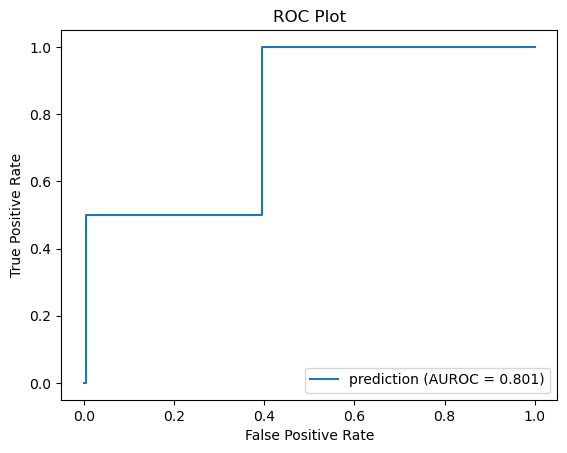

In [159]:
T_W = abs(df_res.fact - df_res.forecast)/df_res.fact
outlier_score = 2*scipy.stats.norm.cdf(T_W)-1

y_true= d2.outliers_mask[500:700].to_numpy()
r_auc=roc_auc_score(y_true,outlier_score)
#print(r_auc)

r_fpr, r_tpr, _ = roc_curve(y_true,outlier_score)
plt.plot(r_fpr, r_tpr, linestyle='-', label= 'prediction (AUROC = %0.3f)' % r_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [122]:
kernel = ConstantKernel() * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=5,
    random_state=2353245)
gpr.fit(d1.x_values[400:500, None], d1.y_values[400:500])
gp1, sigma=gpr.predict(d1.x_values[500:700,None], return_std=True)

df_res = d1[500:700].copy()
df_res['fact'] = test
df_res['forecast'] = gp1
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast)

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold

a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
fig.show()
f,t=df_res.anomaly.value_counts()
print(f'n_outliers = {t}')
f=t/len(test)
print(f'FPR = {f}')

C:\Users\aya_h\AppData\Local\Temp\ipykernel_8496\2784090569.py:6: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aya_h\AppData\Local\Temp\ipykernel_8496\2784090569.py:7: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



n_outliers = 10
FPR = 0.05


In [138]:
gpr.fit(d2.x_values[0:500, None], d2.y_values[0:500])
gp2, sigma=gpr.predict(d2.x_values[500:700,None], return_std=True)

df_res = d2[500:700].copy()
df_res['fact'] = test2
df_res['forecast'] = gp2
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast)

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold

a = df_res.loc[df_res.anomaly, ['fact']]
om = df_res.loc[d2.outliers_mask, ['y_values']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
fig.add_trace(go.Scatter(x=om.index, y=om.y_values, 
                       mode='markers', name='Fact Anomalies',line_color='yellow', opacity=0.5))
fig.update_layout(title=f"T = {len(train)}")
fig.show()
f,t=df_res.anomaly.value_counts()
print(f'n_outliers = {t}')
f=t/len(test)
print(f'FPR = {f}')

C:\Users\aya_h\AppData\Local\Temp\ipykernel_8496\4051735691.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\aya_h\AppData\Local\Temp\ipykernel_8496\4051735691.py:2: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



n_outliers = 10
FPR = 0.05


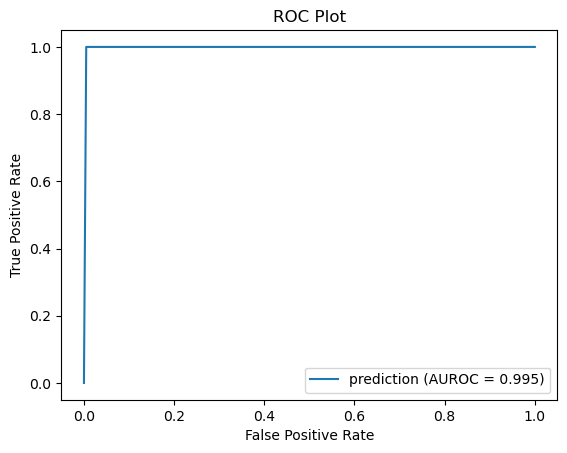

In [149]:
T_W = abs(df_res.fact - df_res.forecast/df_res.fact)
outlier_score = 2*scipy.stats.norm.cdf(T_W)-1
y_true= d2.outliers_mask[500:700].to_numpy()

r_auc=roc_auc_score(y_true,T_W)

r_fpr, r_tpr, _ = roc_curve(y_true,outlier_score)
plt.plot(r_fpr, r_tpr, linestyle='-', label= 'prediction (AUROC = %0.3f)' % r_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()


In [58]:
usd=pd.read_csv(r'C:\Users\aya_h\OneDrive\Desktop\Амира\data.csv',parse_dates=['DATE_USD'],index_col=['DATE_USD'])
usd.LN_USD =usd.LN_USD/100
usd=usd.iloc[:,0:2]
ind = np.arange(len(usd.LN_USD))
usd['x']=ind
usd.head()

,USD,LN_USD,x
DATE_USD,,,
2007-08-20,25.78,NaN,0
2007-08-21,25.87,0.3484,1
2007-08-22,25.77,-0.4066,2
2007-08-23,25.75,-0.0893,3
2007-08-24,25.68,-0.2567,4


In [59]:
x_train = usd.x['2013-08-22':'2014-08-22']
y_train = usd.LN_USD['2013-08-22':'2014-08-22']
x_test = usd.x['2014-08-22':'2015-05-02']
y_test = usd.LN_USD['2014-08-22':'2015-05-02']
print(len(train))
print(len(test))

gpr.fit(x_train[:,None], y_train)
gp1, sigma=gpr.predict(x_test[:,None], return_std=True)

df_res = usd['2014-08-22':'2015-05-02'].copy()
df_res['fact'] = y_test
df_res['forecast'] = gp1
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast) 
    
threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold
a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="Логарифм отношения котитровок USD/RUB")

100
200


In [60]:
a = df_res.loc[df_res.anomaly, ['USD']]
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_res.index, y=df_res.USD, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.USD, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="USD/RUB")

In [61]:
GZP=pd.read_csv(r'C:\Users\aya_h\OneDrive\Desktop\Амира\data.csv',parse_dates=['DATE_GZP'],index_col=['DATE_GZP'])

GZP.LN_GZP =GZP.LN_GZP/100
GZP=GZP.iloc[:3896,9:11]
ind = np.arange(len(GZP.LN_GZP))
GZP['x']=ind

x_train = GZP.x['2011-05-24':'2014-06-24']
y_train = GZP.LN_GZP['2011-05-24':'2014-06-24']
x_test = GZP.x['2014-06-24':'2015-01-05']
y_test = GZP.LN_GZP['2014-06-24':'2015-01-05']

gpr.fit(x_train[:,None], y_train)
gp1, sigma=gpr.predict(x_test[:,None], return_std=True)
df_res = GZP['2014-06-24':'2015-01-05'].copy()
df_res['fact'] = y_test
df_res['forecast'] = gp1
df_res.loc[df_res['fact'] == 0, 'MAPE'] = 0.05
df_res.loc[df_res['fact'] != 0 , 'MAPE'] = abs(df_res.fact - df_res.forecast) 

threshold = percentile(df_res.MAPE, 95)
df_res['anomaly'] =df_res.MAPE > threshold

a = df_res.loc[df_res.anomaly, ['fact']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))

In [64]:
a = df_res.loc[df_res.anomaly, ['GZP']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.GZP, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.GZP, 
                       mode='markers', name='Anomalies'))

In [68]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(d2.y_values[:,None])
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=0.01)
model.fit(data)
d2['anomaly'] = model.predict(data)
a = d2.loc[d2.anomaly == -1, ['y_values']]

om = d2.loc[d2.outliers_mask, ['y_values']]

fig = go.Figure()
fig.add_trace(go.Scatter(x=d2.index, y=d2.y_values, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.y_values, 
                       mode='markers', name='Pred Anomalies'))
fig.add_trace(go.Scatter(x=om.index, y=om.y_values, 
                       mode='markers', name='Fact Anomalies',line_color='yellow', opacity=0.5))
fig.update_layout(title=f"T = {len(train)}")
fig.show()
f,t=d2.anomaly.value_counts()
print(f'n_outliers = {t}')
f=t/len(test)
print(f'FPR = {f}')

n_outliers = 98
FPR = 0.49


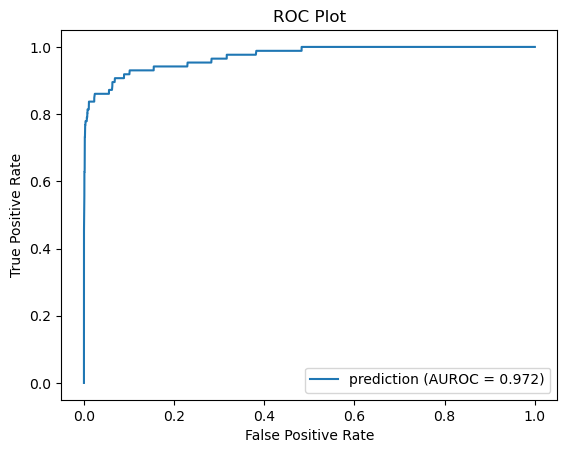

In [69]:
y_true = d2.outliers_mask.to_numpy()
y_pred = model.score_samples(data)

r_auc = roc_auc_score(y_true,-y_pred)

r_fpr, r_tpr, _ = roc_curve(y_true,-y_pred)
plt.plot(r_fpr, r_tpr, linestyle='-', label= 'prediction (AUROC = %0.3f)' % r_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # 
plt.show()

In [70]:
usd=usd['2014-08-22':'2015-05-02']
np_scaled = scaler.fit_transform(usd.USD[:,None])
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=0.10)
model.fit(data)

df_res = usd.copy()
df_res['anomaly'] = model.predict(data)
df_res['fact'] = usd.USD
a = df_res.loc[df_res.anomaly == -1 , ['fact']]

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="Логарифм отношения котитровок USD/RUB")

In [71]:
usd=usd['2014-08-22':'2015-05-02']
scaler = StandardScaler()
np_scaled = scaler.fit_transform(usd.LN_USD[:,None])
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=0.10)
model.fit(data)

df_res = usd.copy()

df_res['anomaly'] = model.predict(data)

df_res['fact'] = usd.LN_USD

a = df_res.loc[df_res.anomaly == -1 , ['fact']]

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))


In [72]:
GZP = GZP['2014-06-24':'2015-01-05']
scaler = StandardScaler()
np_scaled = scaler.fit_transform(GZP.GZP[:,None])
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=0.10)
model.fit(data)

df_res = GZP.copy()

df_res['anomaly'] = model.predict(data)

df_res['fact'] = GZP.GZP

a = df_res.loc[df_res.anomaly == -1 , ['fact']]

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
#fig.update_layout(title="Логарифм отношения котитровок USD/RUB")

In [73]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(GZP.LN_GZP[:,None])
data = pd.DataFrame(np_scaled)
model = IsolationForest(contamination=0.10)
model.fit(data)

df_res = GZP.copy()
df_res['anomaly'] = model.predict(data)
df_res['fact'] = GZP.LN_GZP

a = df_res.loc[df_res.anomaly == -1 , ['fact']]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_res.index, y=df_res.fact, 
                        mode='lines', name='time series'))
fig.add_trace(go.Scatter(x=a.index, y=a.fact, 
                       mode='markers', name='Anomalies'))
